In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from numpy import linalg as LA
from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.optimize import minimize


%matplotlib inline

In [157]:
my_data = pd.read_csv('/home/lin/教材/MearchineLearning/assignmentOneData/48EqualWeighted.csv')

my_data['Unnamed: 0'] = pd.to_datetime(my_data['Unnamed: 0'])

print( np.unique(my_data['Unnamed: 0']).shape, my_data['Unnamed: 0'].shape)

my_data.set_index('Unnamed: 0', inplace = True)
N_ASSET = my_data.shape[1]
fiveY = my_data[-1250 :]
fiveY.shape
tenY = my_data[-2500 :]
tenY.shape

(12196,) (12196,)


(2500, 48)

In [158]:
def stationarity_tests(data, print_info=True):
    adf_p = adfuller(data)[1]
    KPSS_p = kpss(data)[1]
    
    if print_info:
        print('adfuller test')
        print(adfuller(data)[1])
        print('KPSS test')
        print(kpss(data)[1])
        
    return adf_p, KPSS_p


In [159]:
for col in my_data:
    print(col)
    stationarity_tests(my_data[col])

Agric


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller test
0.0
KPSS test
0.1
Food
adfuller test
6.656067591938689e-30
KPSS test
0.1
Soda
adfuller test
0.0
KPSS test
0.1
Beer
adfuller test
0.0
KPSS test
0.0820848062997145
Smoke
adfuller test
0.0
KPSS test
0.1
Toys
adfuller test
3.636059621360826e-30
KPSS test
0.1
Fun
adfuller test
2.523256513702265e-29
KPSS test
0.1
Books
adfuller test
5.874142434186841e-30
KPSS test
0.1
Hshld
adfuller test
1.4697479118689687e-29
KPSS test
0.1
Clths
adfuller test
0.0
KPSS test
0.1
Hlth
adfuller test
4.351872540044763e-29
KPSS test
0.1
MedEq
adfuller test
1.9047402224429343e-29
KPSS test
0.1
Drugs
adfuller test
0.0
KPSS test
0.1
Chems
adfuller test
0.0
KPSS test
0.1
Rubbr
adfuller test
7.834195063528885e-30
KPSS test
0.1
Txtls
adfuller test
1.640337235216711e-29
KPSS test
0.1
BldMt
adfuller test
5.320163650517307e-30
KPSS test
0.1
Cnstr
adfuller test
6.429923456244369e-30
KPSS test
0.1
Steel
adfuller test
2.17581259887352e-30
KPSS test
0.1
FabPr
adfuller test
4.910987211830873e-30
KPSS test
0.1
Mac

In [160]:
for col in fiveY:
    print(col)

    stationarity_tests(fiveY[col])

Agric
adfuller test
3.0568168884433498e-30
KPSS test
0.1
Food


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


adfuller test
0.0
KPSS test
0.03229607238657652
Soda
adfuller test
0.0
KPSS test
0.1
Beer
adfuller test
0.0
KPSS test
0.09368404526781121
Smoke
adfuller test
0.0
KPSS test
0.1
Toys
adfuller test
0.0
KPSS test
0.0667355216979678
Fun
adfuller test
0.0
KPSS test
0.1
Books
adfuller test
2.037348760642201e-30
KPSS test
0.05569556846153647
Hshld
adfuller test
0.0
KPSS test
0.1
Clths
adfuller test
4.934204712696484e-25
KPSS test
0.1
Hlth
adfuller test
0.0
KPSS test
0.09829774426147389
MedEq
adfuller test
0.0
KPSS test
0.1
Drugs
adfuller test
5.579116465853747e-27
KPSS test
0.1
Chems
adfuller test
0.0
KPSS test
0.1
Rubbr
adfuller test
0.0
KPSS test
0.1
Txtls
adfuller test
3.312947811110273e-30
KPSS test
0.02226185490777036
BldMt
adfuller test
3.961104001052471e-18
KPSS test
0.1
Cnstr
adfuller test
0.0
KPSS test
0.1
Steel
adfuller test
4.5767315270021156e-30
KPSS test
0.1
FabPr
adfuller test
1.767296396361912e-26
KPSS test
0.1
Mach
adfuller test
0.0
KPSS test
0.1
ElcEq
adfuller test
0.0
KPSS te

### for features I will use mean-var, correlations. Theoretically, I can use 12K returns as 12K features for each asset, however, it is a extreme high dimentional problem, and even if you get the results, it is gonna be super difficult to interperate. OK I'll use 5 years returns as features too. In  K-means this is actually measure the the euclidean distance of the returns vectors so should expect the more similar the return series are, the closer they are so this should be similar to the correlation features result.

In [161]:
def get_feature_Matrices(data):
    meanVar = pd.DataFrame(columns=['mean', 'var'], index=data.columns, dtype=float)
    MI = pd.DataFrame(index=data.columns, columns=data.columns, dtype=float)

    for col in data.columns:
        meanVar['mean'][col] = data[col].mean()
        meanVar['var'][col] = data[col].var()
        for ref_col in data.columns:
            MI[ref_col][col] = metrics.mutual_info_score(data[ref_col], data[col])

    pearson = data.corr()
    kendall = data.corr(method='kendall')
    spearman = data.corr(method='spearman')
    
    return meanVar, pearson, kendall, spearman, MI


In [162]:
MV, corr, Ken, Spe, MI = get_feature_Matrices(fiveY)

In [163]:
normdFY = pd.DataFrame(columns=fiveY.columns, index=fiveY.index, dtype=float)
for col in fiveY:
    normdFY[col] = (fiveY[col] - MV['mean'][col]) / (MV['var'][col]**0.5)

## This is my own naive way

In [164]:
def choose_K(featureMa, plot=True, labelS=22, tS=22):
    
    sumDis = pd.DataFrame(columns=['sumDisSq', 'bm'], index=range(1, 49), dtype=float)
    bm = np.random.rand(featureMa.shape[0], featureMa.shape[1])
    for i in range(1, 49):

        kmeans = KMeans(n_clusters=i).fit(featureMa)
        sumDis['sumDisSq'][i] = kmeans.inertia_ 
        kmeansBM = KMeans(n_clusters=i).fit(bm)
        sumDis['bm'][i] = kmeansBM.inertia_ 
    print(abs(sumDis.diff()[abs(sumDis.diff()['sumDisSq']) > abs(sumDis.diff()['bm'])]))
    if plot:
        plt.plot(abs(sumDis.diff()), '-2')
        plt.legend(['data', 'benchmark'], fontsize=labelS)
        plt.xlabel('K', fontsize=labelS)
        plt.ylabel(r'absolute reduction in $\sum_{a=1}^{K} W(C_{a})$', fontsize=labelS)
        plt.title('K values vs reduction in loss function', fontsize=tS)
    return sumDis

Document of K-means  http://scikit-learn.org/stable/modules/clustering.html#k-means
http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


Given enough time, K-means will always converge, however this may be to a local minimum. This is highly dependent on the initialization of the centroids. As a result, the computation is often done several times, with different initializations of the centroids. One method to help address this issue is the k-means++ initialization scheme, which has been implemented in scikit-learn (use the init='k-means++' parameter). This initializes the centroids to be (generally) distant from each other, leading to provably better results than random initialization, as shown in the reference.

n_init = 10

Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

The k-means problem is solved using Lloyd’s algorithm.

In [166]:
%matplotlib tk
normFsumDis = choose_K(normdFY)

        sumDisSq         bm
2   21014.406070  96.079057
3    6605.433474  71.287453
4    2973.410023  54.287416
5    1589.577840  41.936497
6    1006.650186  39.657154
7     648.301403  36.577525
8     452.348839  31.538558
9     351.044821  31.358752
10    325.841354  29.581693
11    248.179238  15.944911
12    264.982354  28.545326
13    286.470732  19.888091
14    170.797127  22.337659
15    238.288491  19.662470
16    288.022612  14.065167
17    118.002965  24.929281
18    210.305111  23.157474
19     69.724001  12.093102
20    163.739913  11.207043
21    167.821894  13.533674
22    127.519364  14.071315
23     39.487458  12.836707
24    200.254421  15.600828
25    150.374286  16.181566
26     31.551837  18.093428
27    107.733915  15.146373
28     84.782020   2.232249
29    116.514012  10.369466
30     44.792739  15.372824
31    174.215734  10.472059
32     24.119218   4.009957
33    182.213093  15.478012
34     94.591330  12.934856
35     19.605017  14.960627
36    126.030362   9

      sumDisSq        bm
2   104.416009  3.007324
3    18.022679  1.871419
4     3.322492  0.643617
5     1.881386  0.543652
6     0.974879  0.147626
7     0.488060  0.123133
8     0.374060  0.090362
9     0.228691  0.097484
10    0.185267  0.049731


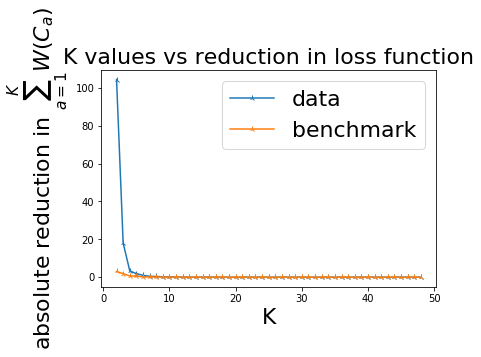

In [7]:
MVsumDis = choose_K(MV)

0
Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Chems', 'Rubbr', 'Txtls', 'BldMt',
       'Cnstr', 'Mach', 'ElcEq', 'Autos', 'Aero', 'Guns', 'Util', 'Telcm',
       'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans',
       'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin', 'Other'],
      dtype='object')
1
Index(['Gold', 'Coal'], dtype='object')
2
Index(['Drugs', 'Steel', 'FabPr', 'Ships', 'Mines', 'Oil'], dtype='object')


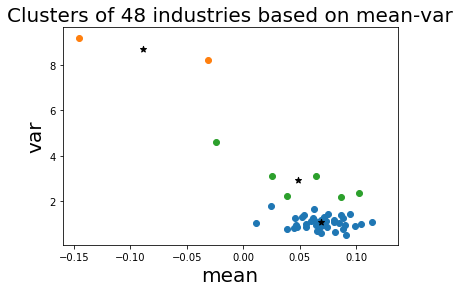

In [8]:
MVChoise = 3
kmeans = KMeans(MVChoise).fit(MV)
MV['cluster'] = kmeans.labels_ 
for j in range(MVChoise):
    print(j)
    print(MV[MV['cluster']==j].index)
    plt.scatter(MV['mean'][MV['cluster'] == j], MV['var'][MV['cluster'] == j])
    plt.scatter(kmeans.cluster_centers_[j][0], kmeans.cluster_centers_[j][1], marker='*', s=40, c='k')
    plt.xlabel('mean', fontsize=20)
    plt.ylabel('var', fontsize=20)
    plt.title('Clusters of 48 industries based on mean-var', fontsize=20)


    sumDisSq         bm
2  23.114297  10.552337
0
Index(['Food', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs',
       'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'Mach', 'ElcEq',
       'Autos', 'Aero', 'Ships', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips',
       'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks',
       'Insur', 'RlEst', 'Fin'],
      dtype='object')
1
Index(['Agric', 'Soda', 'Beer', 'Smoke', 'Toys', 'FabPr', 'Guns', 'Gold',
       'Mines', 'Coal', 'Oil', 'Util', 'Other'],
      dtype='object')


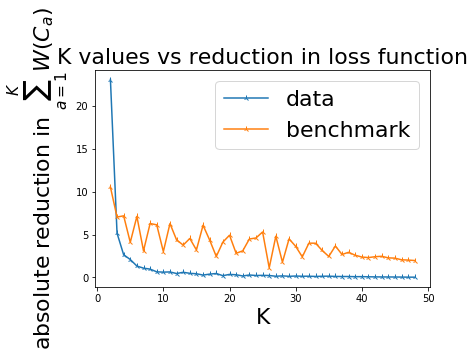

In [9]:
PearsonSumDis = choose_K(corr)
choise = 2
kmeans = KMeans(choise).fit(corr)
corr['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(corr[corr['cluster']==j].index)

    sumDisSq        bm
2  12.506596  9.344807
0
Index(['Agric', 'Soda', 'Beer', 'Smoke', 'FabPr', 'Guns', 'Gold', 'Mines',
       'Coal', 'Oil', 'Util'],
      dtype='object')
1
Index(['Food', 'Toys', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq',
       'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'Mach',
       'ElcEq', 'Autos', 'Aero', 'Ships', 'Telcm', 'PerSv', 'BusSv', 'Comps',
       'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals',
       'Banks', 'Insur', 'RlEst', 'Fin', 'Other'],
      dtype='object')


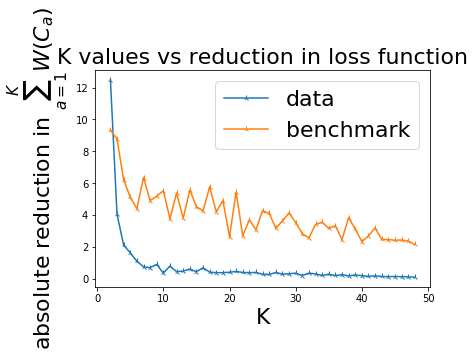

In [10]:
KenSumDis = choose_K(Ken)
choise = 2
kmeans = KMeans(choise).fit(Ken)
Ken['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(Ken[Ken['cluster']==j].index)

    sumDisSq         bm
2  18.879236  10.760746
0
Index(['Agric', 'Food', 'Toys', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth',
       'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel',
       'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero', 'Ships', 'Guns', 'Mines',
       'Oil', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper',
       'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst',
       'Fin', 'Other'],
      dtype='object')
1
Index(['Soda', 'Beer', 'Smoke', 'Gold', 'Coal', 'Util'], dtype='object')


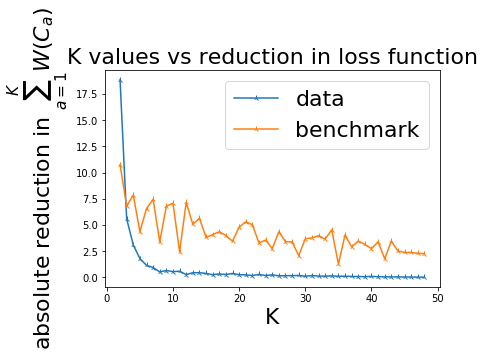

In [11]:
SpeSumDis = choose_K(Spe)
choise = 2
kmeans = KMeans(choise).fit(Spe)
Spe['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(Spe[Spe['cluster']==j].index)

     sumDisSq         bm
2   56.444886  10.283822
3   13.380586   8.108569
4    8.647951   6.806681
12   2.601536   1.139720
15   1.963073   1.810345
18   2.219164   1.849904
25   1.940357   1.629943
0
Index(['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books',
       'Hshld', 'Clths', 'Hlth', 'MedEq', 'Chems', 'Rubbr', 'Txtls', 'BldMt',
       'Mach', 'ElcEq', 'Autos', 'Aero', 'Guns', 'Util', 'Telcm', 'PerSv',
       'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl',
       'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin', 'Other'],
      dtype='object')
1
Index(['Drugs', 'Cnstr', 'Steel', 'FabPr', 'Ships', 'Gold', 'Mines', 'Coal',
       'Oil'],
      dtype='object')


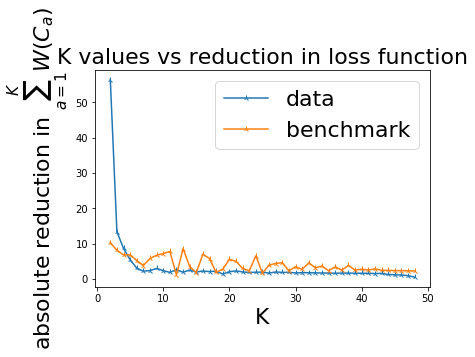

In [12]:
MISumDis = choose_K(MI)
choise = 2
kmeans = KMeans(choise).fit(MI)
MI['cluster'] = kmeans.labels_ 
for j in range(choise):
    print(j)
    print(MI[MI['cluster']==j].index)

In [13]:
def hard_core_W(featureMa):
    
    newGroup = featureMa.groupby(by='cluster')
    DifW = 0.0
    for key, item in newGroup:
        oneClus = pd.DataFrame(newGroup.get_group(key), dtype=float).drop('cluster', axis=1)
        sumD = 0.0
        for asset1 in oneClus.index:
            vec1 = oneClus[oneClus.index==asset1]
            for asset2 in oneClus.index:
                vec2 = oneClus[oneClus.index==asset2]
                norm = LA.norm(np.asarray(vec1) - np.asarray(vec2))**2
                sumD = sumD + norm
        intoW = sumD/(oneClus.shape[0] * 2)
        DifW = DifW + intoW
    print(DifW)
#These two are the same thing, notes page 9


## This is using gap statistics

Gap paper


In [42]:
def gap_choose(featureMa, B=10):
    sumDis = pd.DataFrame(columns=['sumDisSq', 'bm', 'Elogbm', 'stBm', 'Gapk', 'sk'], index=range(1, 48), dtype=float)
    for i in range(1, 48):
        kmeans = KMeans(n_clusters=i).fit(featureMa)
        sumDis['sumDisSq'][i] = np.log(kmeans.inertia_)
        Wseries = pd.DataFrame(columns=['Wref'], index=range(B), dtype=float)

        for j in range(B):
            bm = pd.DataFrame(columns=featureMa.columns, index=featureMa.index, dtype=float)
            for col in featureMa.columns:
                up = max(featureMa[col])
                down = min(featureMa[col])
                ran = up - down
                bm[col] = np.random.rand(len(featureMa[col])) * ran + down
                
            kmeansBM = KMeans(n_clusters=i).fit(bm)
            Wseries['Wref'][j] = kmeansBM.inertia_
        sumDis['Elogbm'][i] = np.mean(np.log(Wseries['Wref']))
        sumDis['bm'][i] = np.mean(Wseries['Wref'])
        sumDis['stBm'][i] = np.std(np.log(Wseries['Wref']))

    sumDis['Gapk'] = sumDis['Elogbm'] - sumDis['sumDisSq']
    sumDis['sk'] = sumDis['stBm'] * (1 + 1 / B) ** 0.5
    sumDis['tocompare'] = (sumDis['Gapk'] - sumDis['sk']).shift(-1)
    return sumDis

In [45]:
def present_K_choice(sumMa, labelS=22, tS=22):
    plt.figure()
    plt.plot(np.exp(sumMa['sumDisSq']), '-2r')
    plt.plot(sumMa['bm'], '-2b')
    plt.legend(['data', 'benchmark'], fontsize=labelS)
    plt.xlabel('K', fontsize=labelS)
    plt.ylabel(r'$\sum_{a=1}^{K} W(C_{a})$', fontsize=labelS)
    plt.title('K values vs within sum of squares', fontsize=tS)
    plt.grid(True)
    
    plt.figure()
    plt.plot(sumMa['sumDisSq'], '-or')
    plt.plot(sumMa['Elogbm'], '-xb')
    plt.legend(['data', 'benchmark'], fontsize=labelS)
    plt.xlabel('K', fontsize=labelS)
    plt.ylabel(r'$logW_{k}$', fontsize=labelS)
    plt.title(r'K values vs $logW_{k}$', fontsize=tS)
    plt.grid(True)

    plt.figure()
    plt.plot(sumMa['Gapk'], 'r')
    plt.plot(sumMa['Gapk']+sumMa['sk'], '--g')
    plt.plot(sumMa['Gapk']-sumMa['sk'], '--g')
    plt.legend(['Gap'], fontsize=labelS)
    plt.xlabel('K', fontsize=labelS)
    plt.ylabel('Gaps', fontsize=labelS)
    plt.title('Gaps of different K values', fontsize=tS)
    plt.grid(True)


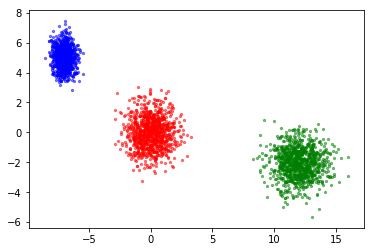

In [28]:
x1 = np.random.randn(1000)
y1 = np.random.randn(1000)
x2 = np.random.randn(1000) * 1.2 + 12
y2 = np.random.randn(1000) - 2
x3 = np.random.randn(1000) * 0.5 - 7
y3 = np.random.randn(1000) * 0.7 + 5

plt.scatter(x1, y1, c='r', s=5, alpha=0.5)
plt.scatter(x2, y2, c='g', s=5, alpha=0.5)
plt.scatter(x3, y3, c='b', s=5, alpha=0.5)

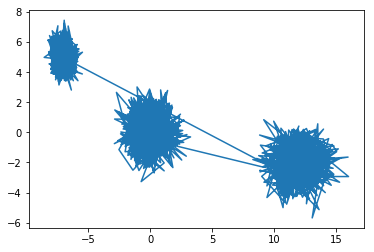

In [34]:
x = np.append(x1, x2)
x = np.append(x, x3)
y = np.append(y1, y2)
y = np.append(y, y3)

example = pd.DataFrame(dtype=float)
example['x'] = x
example['y'] = y

plt.plot(example['x'], example['y'])

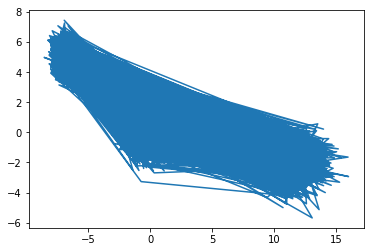

In [38]:
example = example.sample(frac=1).reset_index(drop=True)
plt.plot(example['x'], example['y'])

In [169]:
plt.scatter(example['x'], example['y'], s=5, alpha=0.5)
plt.title('Generated dataset', fontsize=22)

Text(0.5,1,'Generated dataset')

In [170]:
sumEG = gap_choose(example)
present_K_choice(sumEG)

In [49]:
#%matplotlib tk
present_K_choice(sumEG)

In [68]:
MV, corr, Ken, Spe, MI = get_feature_Matrices(fiveY)

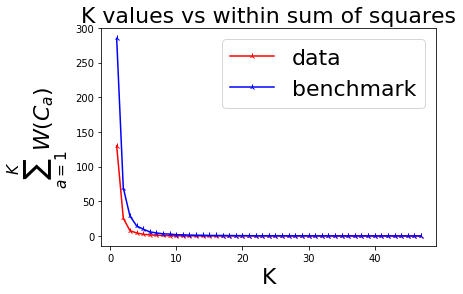

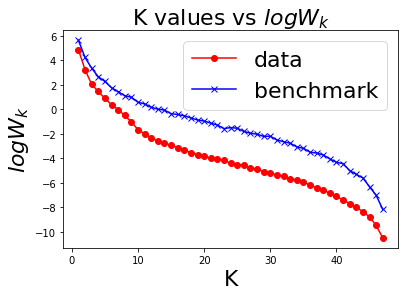

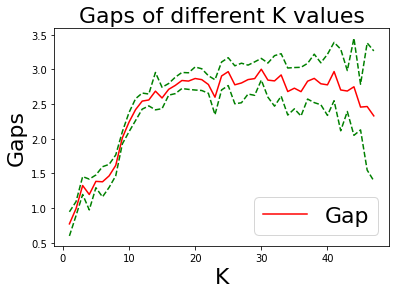

In [17]:
sumMV = gap_choose(MV)
present_K_choice(sumMV)

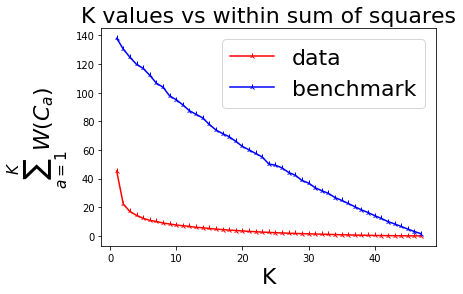

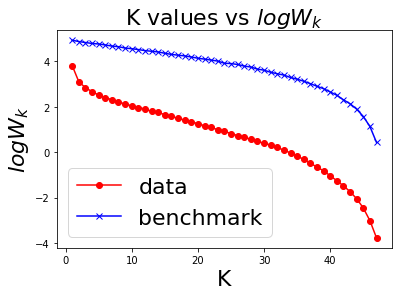

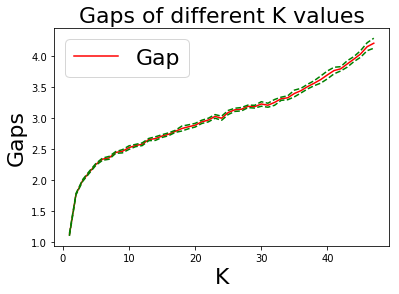

In [18]:
sumPear = gap_choose(corr)
present_K_choice(sumPear)

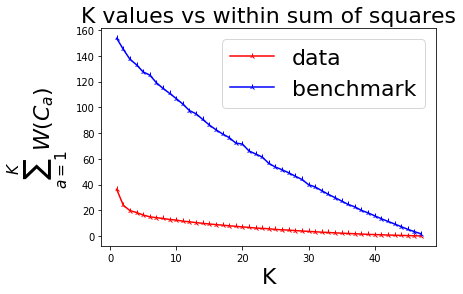

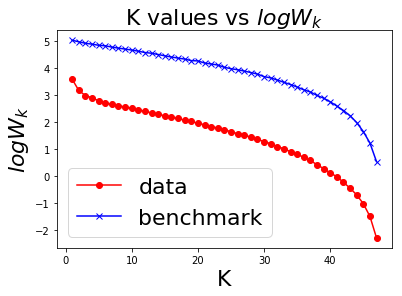

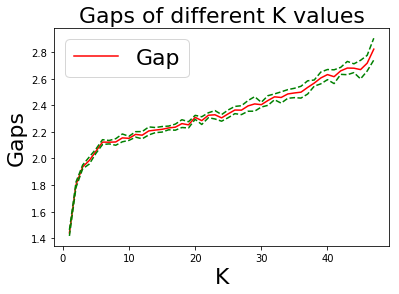

In [19]:
sumKen = gap_choose(Ken)
present_K_choice(sumKen)

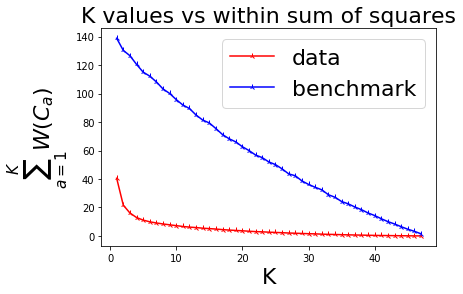

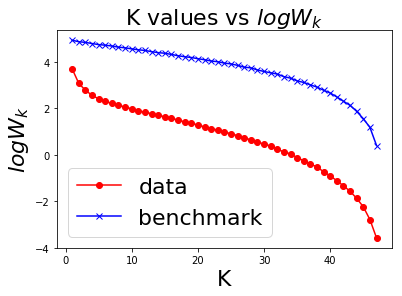

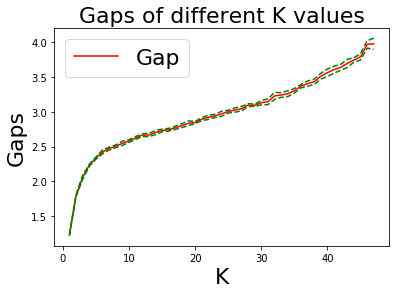

In [20]:
sumSpe = gap_choose(Spe)
present_K_choice(sumSpe)

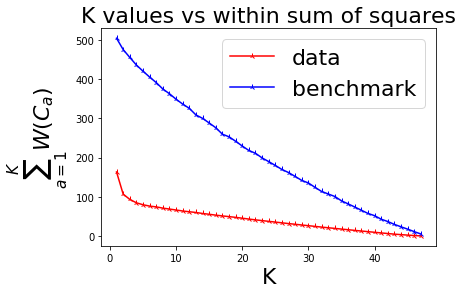

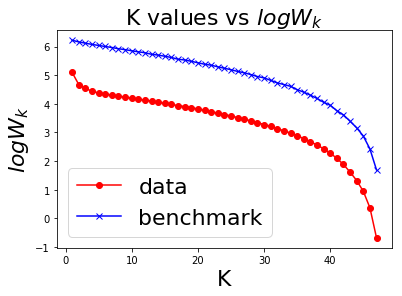

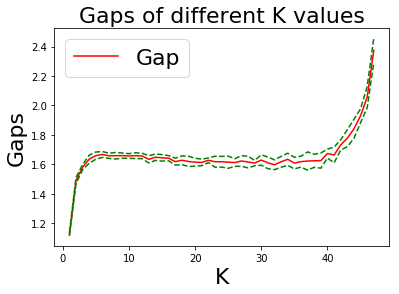

In [21]:
sumMI = gap_choose(MI)
present_K_choice(sumMI)

In [174]:
sumRe = gap_choose(a, B=100)
present_K_choice(sumRe)

In [172]:
a = normdFY.T
a

Unnamed: 0,2012-11-14 00:00:00,2012-11-15 00:00:00,2012-11-16 00:00:00,2012-11-19 00:00:00,2012-11-20 00:00:00,2012-11-21 00:00:00,2012-11-23 00:00:00,2012-11-26 00:00:00,2012-11-27 00:00:00,2012-11-28 00:00:00,...,2017-10-18 00:00:00,2017-10-19 00:00:00,2017-10-20 00:00:00,2017-10-23 00:00:00,2017-10-24 00:00:00,2017-10-25 00:00:00,2017-10-26 00:00:00,2017-10-27 00:00:00,2017-10-30 00:00:00,2017-10-31 00:00:00
Agric,-1.338370,-1.279038,-0.159151,1.865544,0.782740,-0.937880,0.219088,1.272227,-0.092403,0.923653,...,0.500914,-0.937880,0.537996,-0.767302,-0.470643,0.426749,0.248754,0.493498,-1.494115,0.938486
Food,-1.751854,-0.856357,0.972474,1.893196,-0.137437,0.631933,0.669771,0.606708,0.694996,1.149051,...,-0.465366,-0.566267,-0.036536,-0.793294,-0.137437,-0.061762,-0.314014,0.455356,-2.281584,1.704007
Soda,-0.560964,-2.888283,0.453082,1.300892,0.128920,0.652567,1.724796,0.951794,0.835428,0.353340,...,0.178791,-0.112124,-0.810319,-1.608257,0.810492,-0.934997,0.536201,-0.785384,-1.250848,0.918546
Beer,-2.050197,0.867807,-0.373292,1.388879,0.507793,0.223572,-0.032227,-0.695410,-0.505929,0.384631,...,-0.032227,-0.524877,-1.178586,0.896229,-0.771202,-0.714358,0.062514,-0.657514,-0.619617,2.307861
Smoke,-2.823164,-1.026663,2.761389,3.233612,0.667182,0.543993,1.488439,-0.667362,-0.657097,0.780105,...,-0.441516,-1.940312,0.051238,-0.728957,-0.236202,-1.427026,1.190733,-0.770020,-1.714466,-0.123279
Toys,-0.986042,-1.257257,-0.231726,0.827707,0.954839,-0.570745,0.683624,0.031013,-0.367333,2.268536,...,0.607345,-0.172398,1.404039,-2.206509,0.344606,-1.392865,0.200523,-1.367438,-0.138496,-2.181083
Fun,-2.554664,0.326012,2.246463,1.409057,-0.511394,0.839621,0.560486,-0.466732,0.772629,0.649809,...,0.571651,0.125035,-0.087108,-0.332747,0.091539,-1.058499,0.214358,0.593982,-1.281807,0.995937
Books,-1.388884,-1.342587,0.212979,0.879651,0.101867,-0.203690,0.398166,0.842613,0.481500,1.166690,...,0.351869,-0.712953,1.555581,-0.740731,-0.583323,-0.129616,0.546315,-0.324062,-1.138882,0.472240
Hshld,-1.722753,-0.051630,0.390409,1.436208,-0.073193,0.174780,1.490116,-0.191789,0.185562,-0.159445,...,-0.288822,-0.439762,0.735415,-0.137882,-0.073193,-0.019286,-0.051630,-0.439762,-1.075867,0.530568
Clths,-1.454127,-0.120509,0.386265,2.715650,0.457392,0.928603,0.501846,0.386265,1.088637,1.462050,...,0.475173,0.003962,2.697869,0.199559,0.101760,0.261794,0.484064,0.350702,-1.445236,-1.294092


## This is using silhouette statistics

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html#sklearn.metrics.silhouette_samples

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

For n_clusters = 2 The average silhouette_score is : 0.8949537815803472
For n_clusters = 3 The average silhouette_score is : 0.769771428665921
For n_clusters = 4 The average silhouette_score is : 0.7225139422954374
For n_clusters = 5 The average silhouette_score is : 0.537855522685739
For n_clusters = 6 The average silhouette_score is : 0.5675401249278238


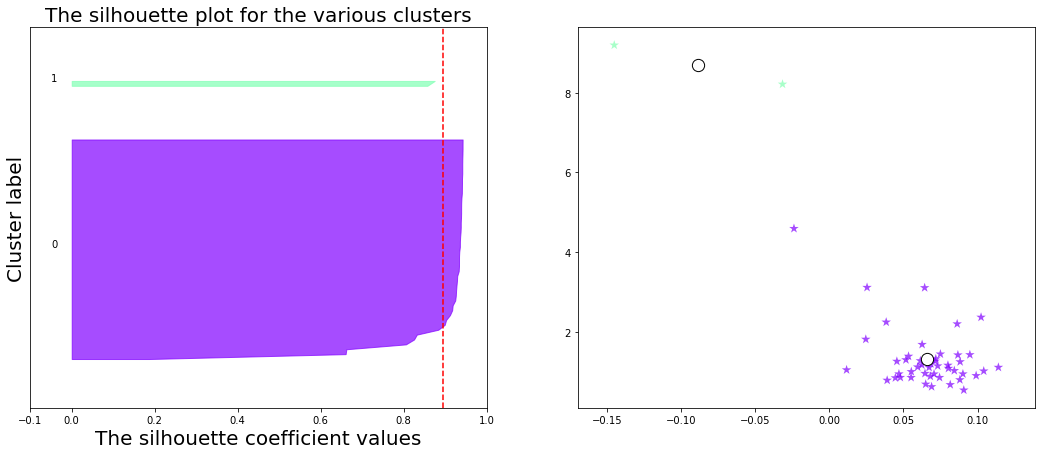

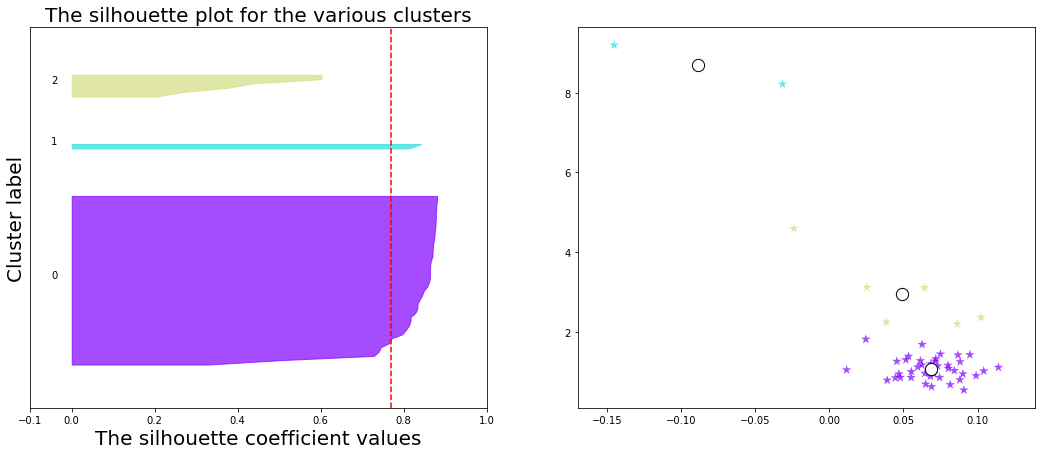

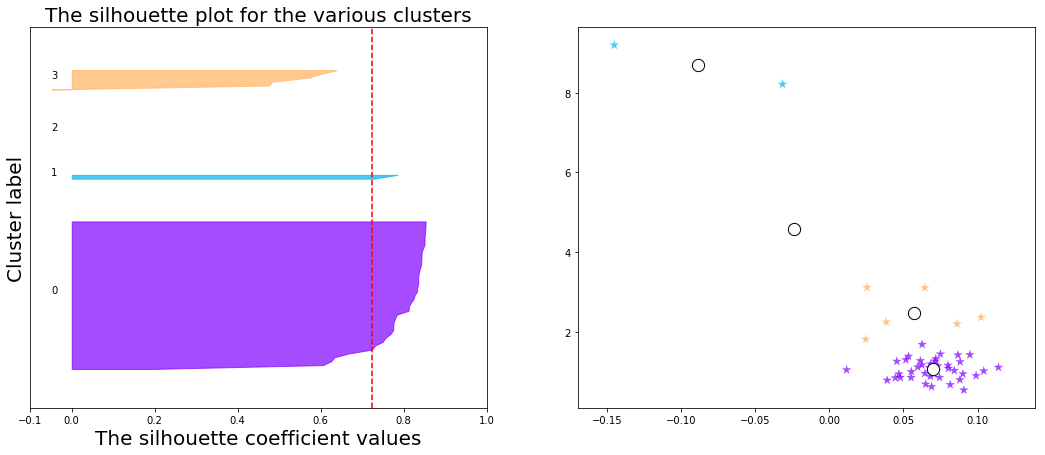

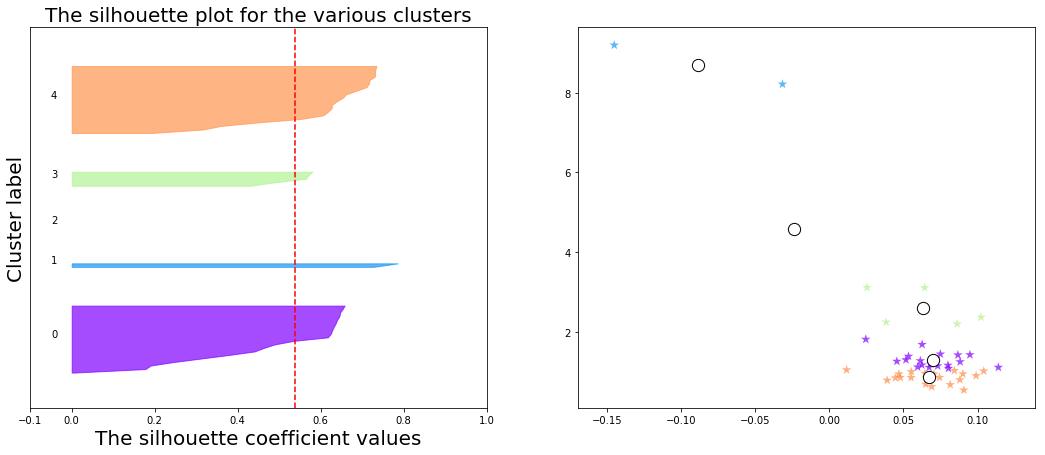

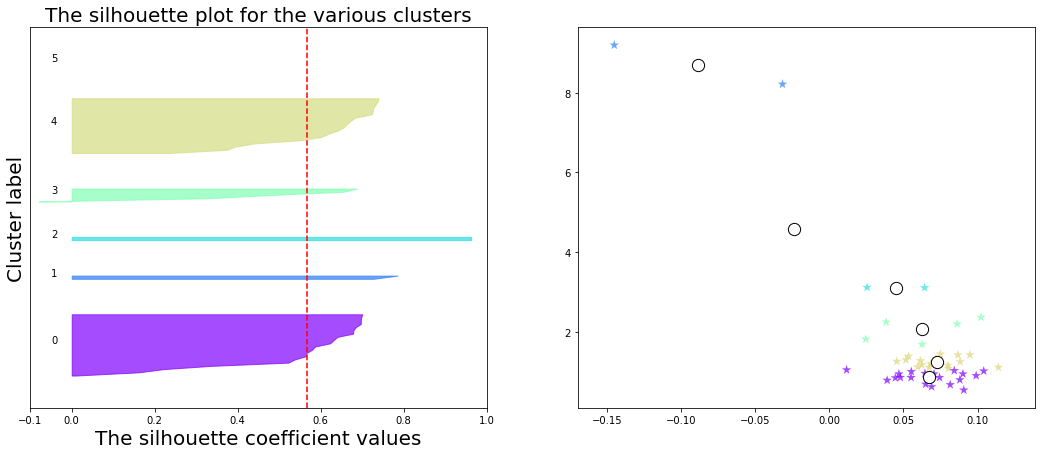

In [69]:
X=MV
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.rainbow(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters", fontsize=20)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=20)
    ax1.set_ylabel("Cluster label", fontsize=20)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.rainbow(cluster_labels.astype(float) / (n_clusters*0.98))
    ax2.scatter(X.values[:, 0], X.values[:, 1], marker='*', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=150, edgecolor='k')


In [70]:

def plot_silhouette(X, range_n_clusters):

    for n_clusters in range_n_clusters:
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)


        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])


        clusterer = KMeans(n_clusters=n_clusters, random_state=None)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):

            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.rainbow(float(i)/n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters", fontsize=20)
        ax1.set_xlabel("The silhouette coefficient values", fontsize=20)
        ax1.set_ylabel("Cluster label", fontsize=20)

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  


For n_clusters = 2 The average silhouette_score is : 0.8949537815803472
For n_clusters = 3 The average silhouette_score is : 0.769771428665921
For n_clusters = 4 The average silhouette_score is : 0.7225139422954374
For n_clusters = 5 The average silhouette_score is : 0.537855522685739
For n_clusters = 6 The average silhouette_score is : 0.5656724089849688


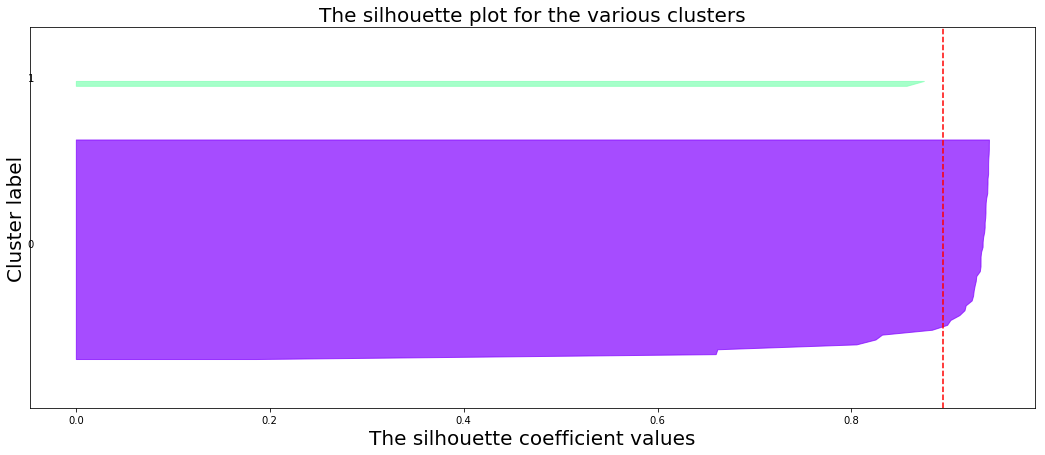

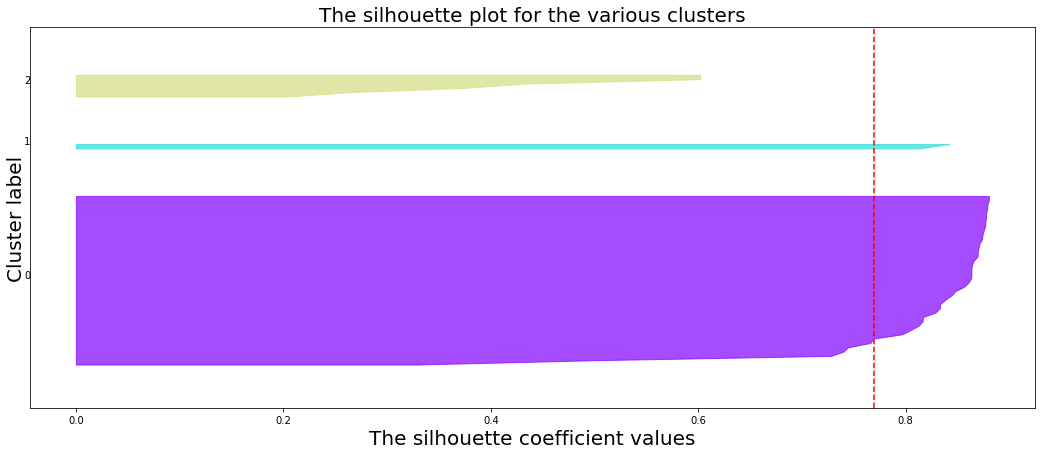

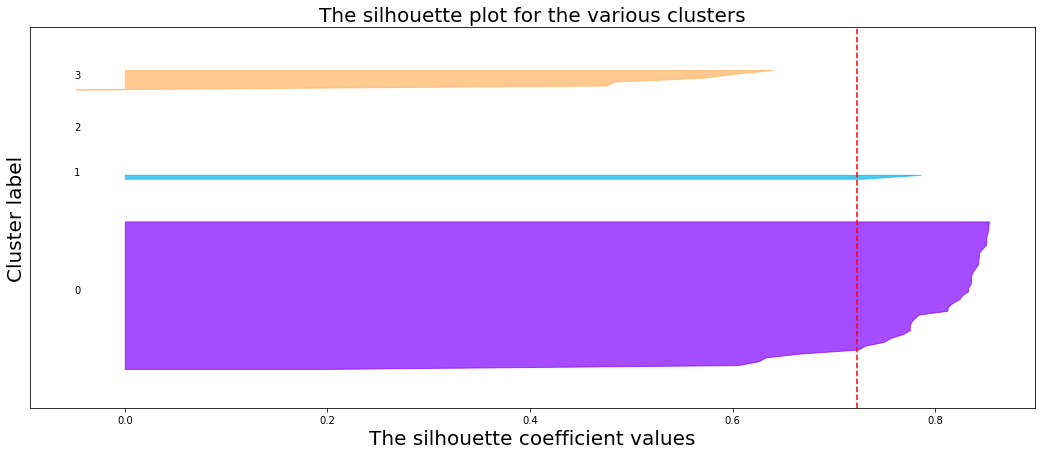

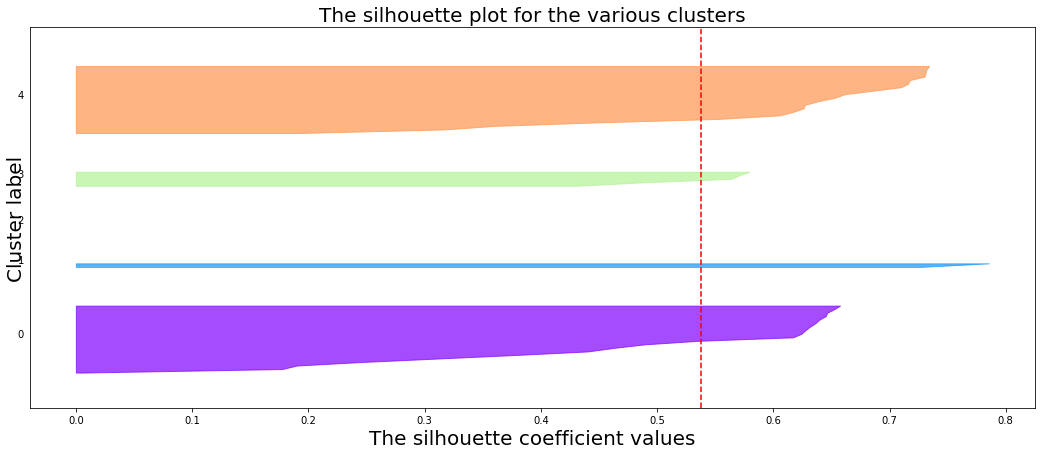

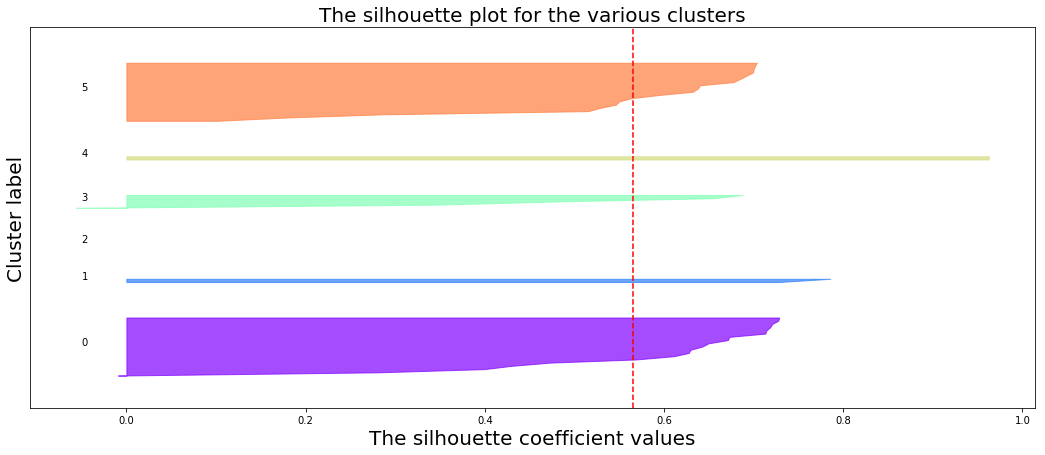

In [71]:
clusters = [ 2, 3, 4, 5, 6]
plot_silhouette(MV, clusters)

For n_clusters = 2 The average silhouette_score is : 0.3421432437188295
For n_clusters = 3 The average silhouette_score is : 0.1689028406414942
For n_clusters = 4 The average silhouette_score is : 0.13888480238162362
For n_clusters = 5 The average silhouette_score is : 0.1073000447221855
For n_clusters = 6 The average silhouette_score is : 0.08161593284345255


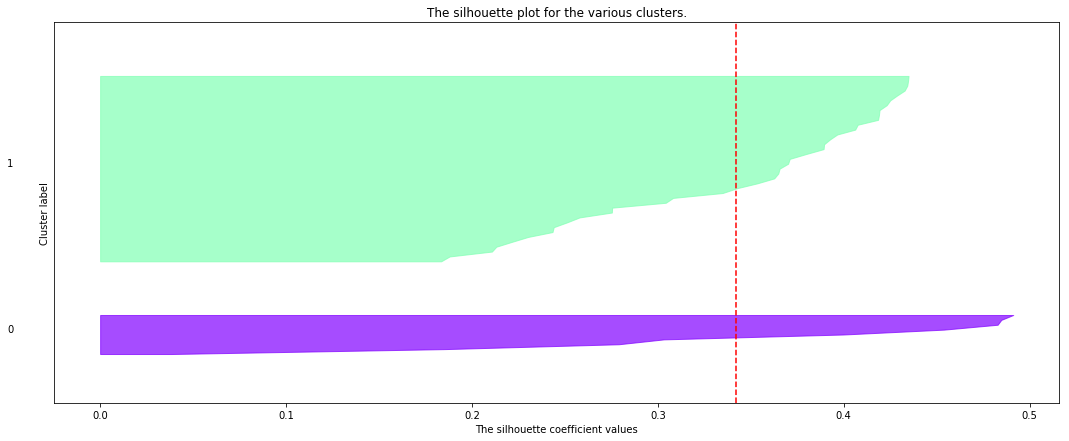

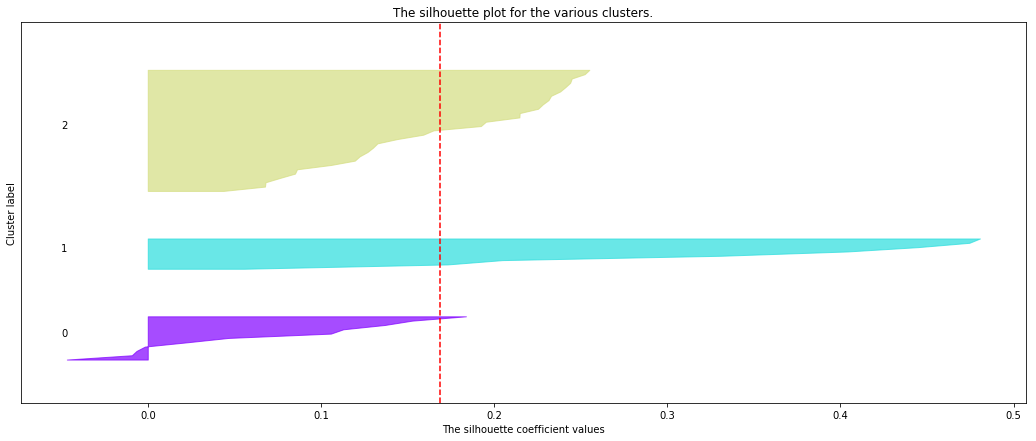

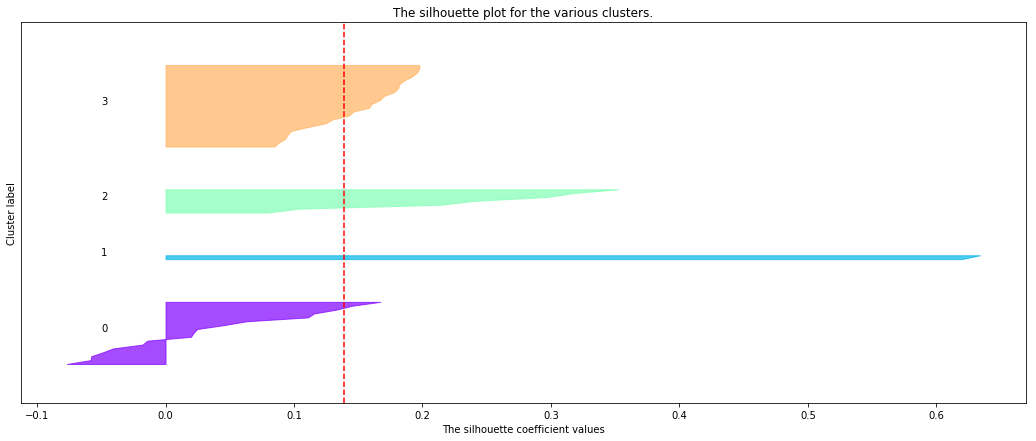

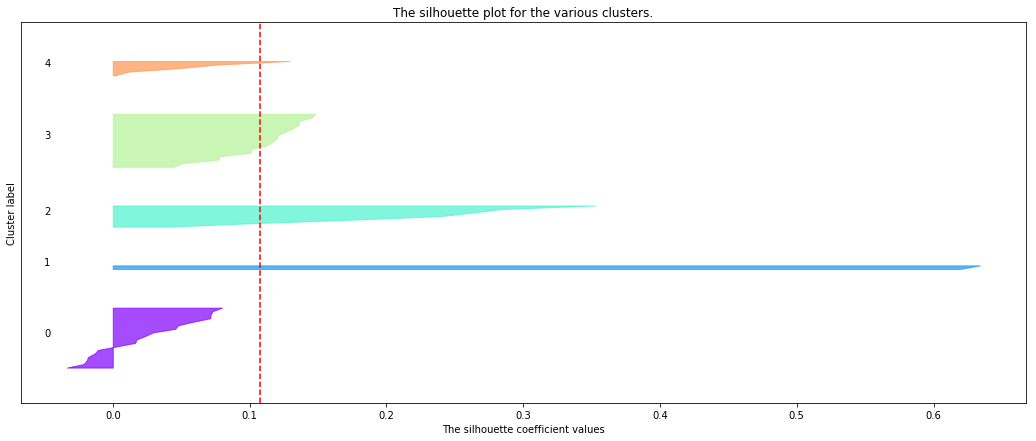

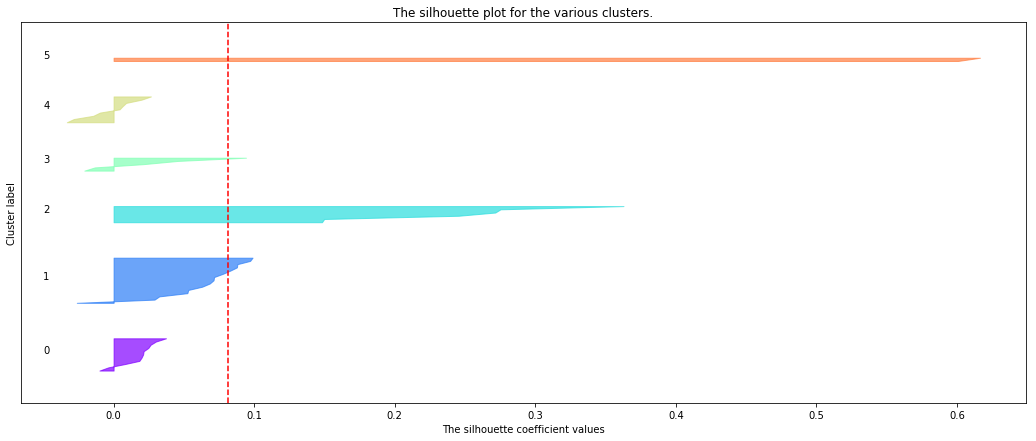

In [26]:
plot_silhouette(MI, clusters)

For n_clusters = 2 The average silhouette_score is : 0.36153817137032895
For n_clusters = 3 The average silhouette_score is : 0.203359781202633
For n_clusters = 4 The average silhouette_score is : 0.20952492030185696
For n_clusters = 5 The average silhouette_score is : 0.19838495112946997
For n_clusters = 6 The average silhouette_score is : 0.1641944008255589


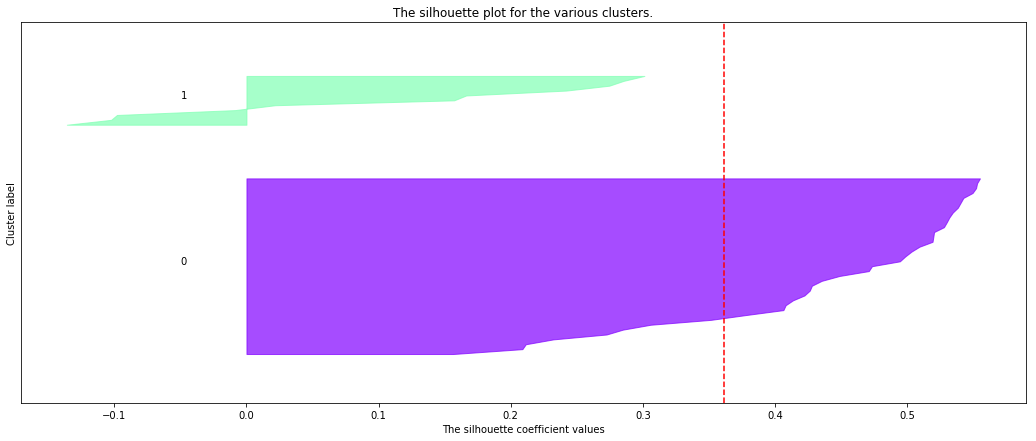

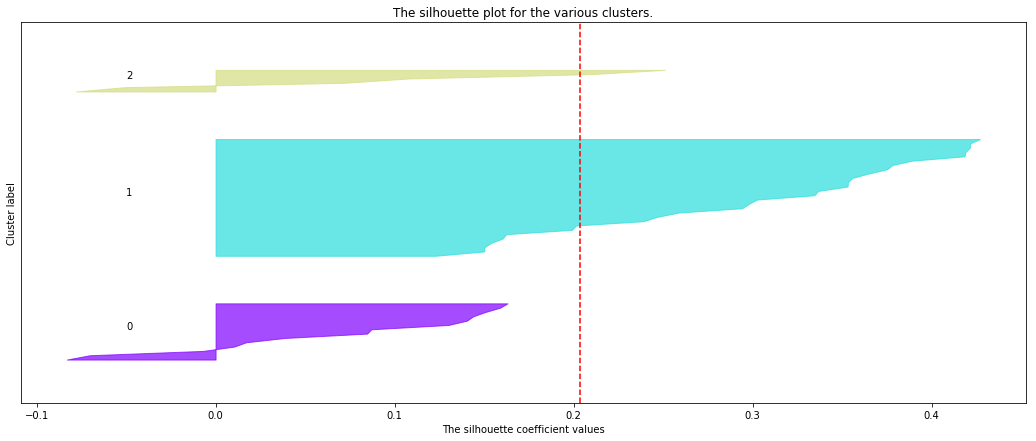

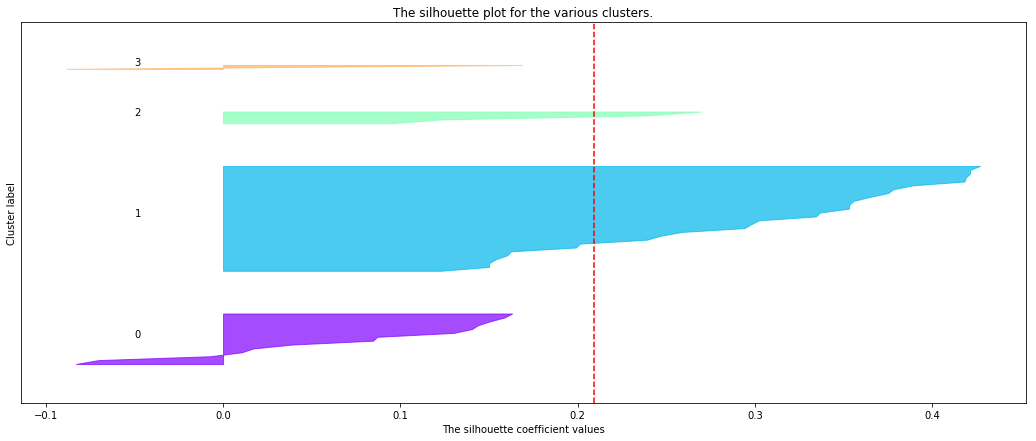

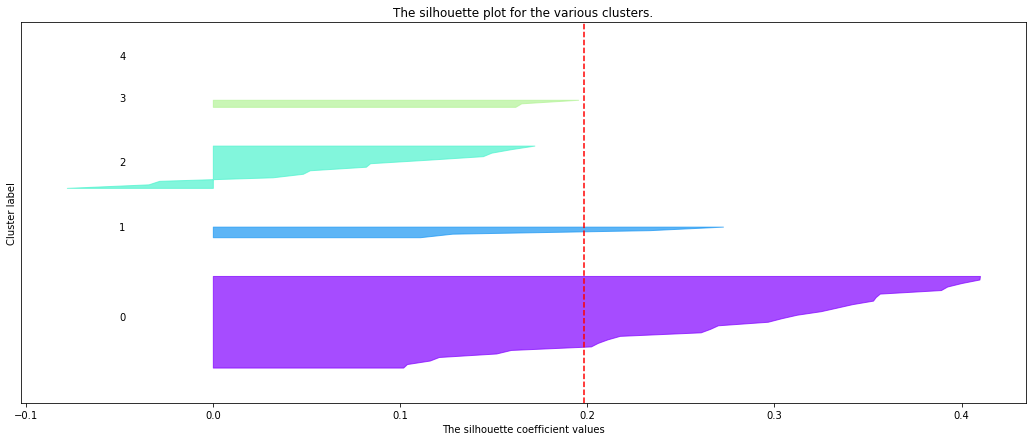

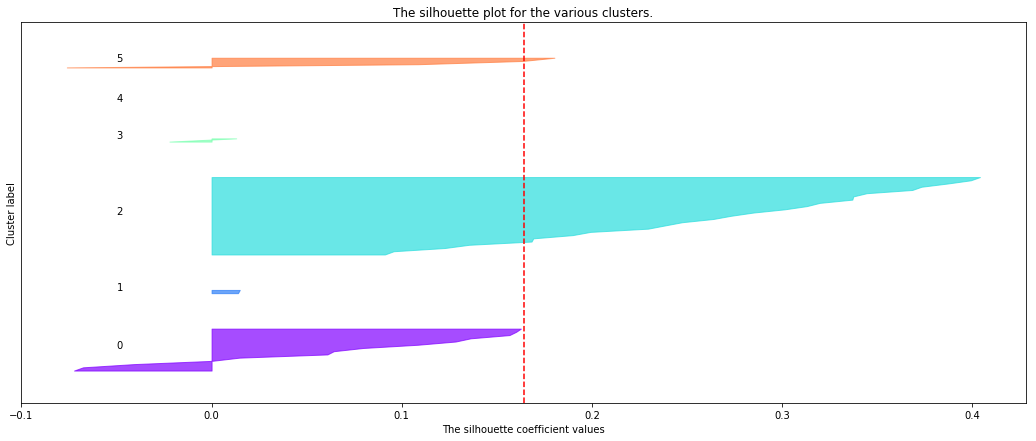

In [27]:
plot_silhouette(Ken, clusters)

For n_clusters = 2 The average silhouette_score is : 0.4853351265717227
For n_clusters = 3 The average silhouette_score is : 0.3579011165519795
For n_clusters = 4 The average silhouette_score is : 0.3671949404291677
For n_clusters = 5 The average silhouette_score is : 0.20229251236405785
For n_clusters = 6 The average silhouette_score is : 0.20060236602942427


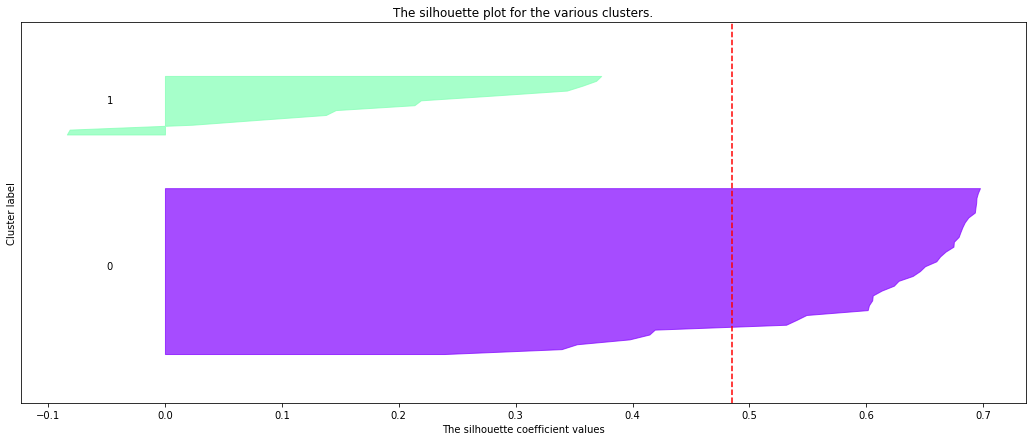

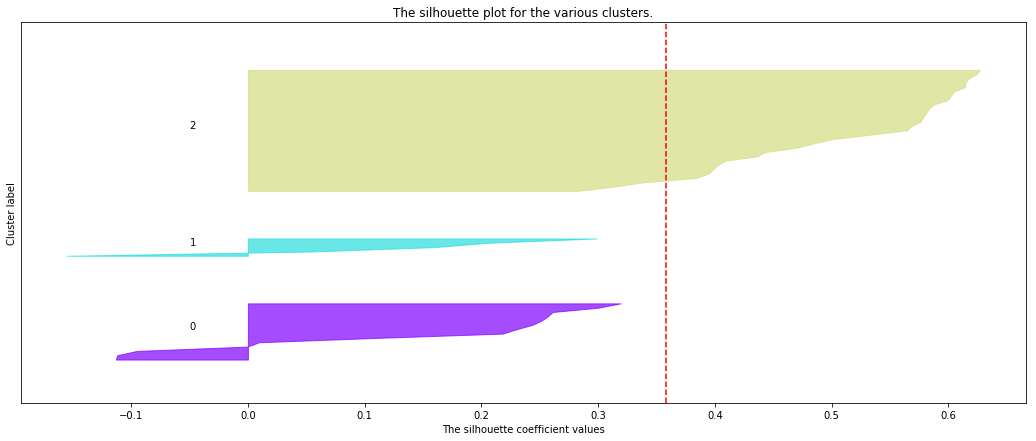

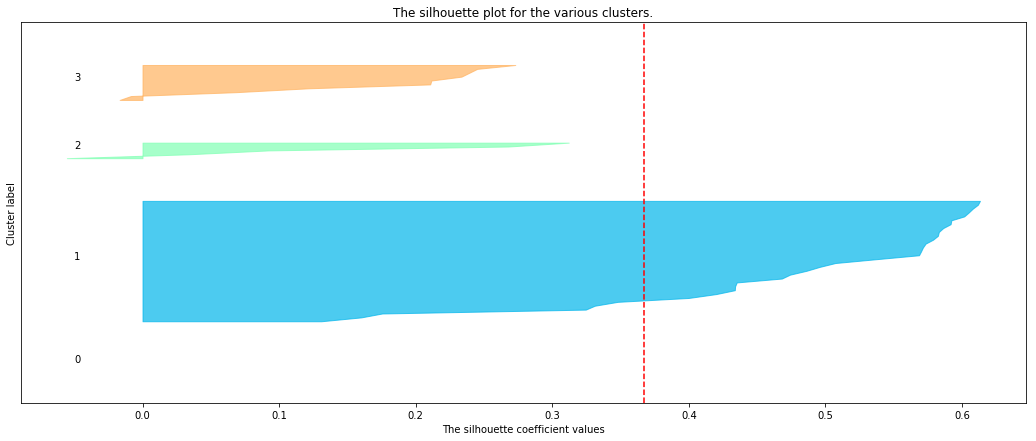

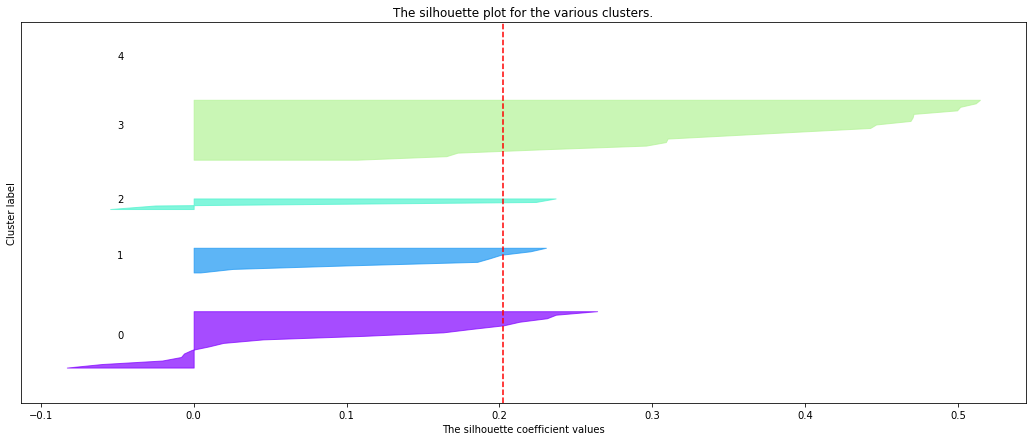

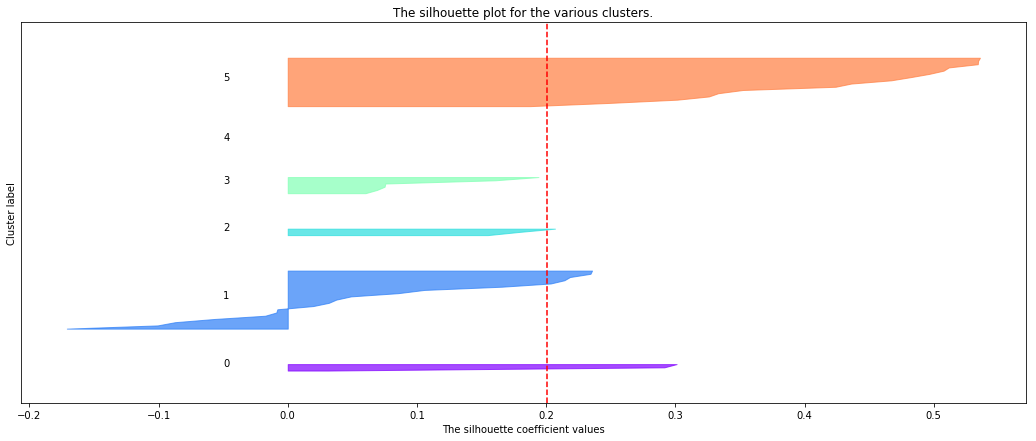

In [28]:
plot_silhouette(corr, clusters)

For n_clusters = 2 The average silhouette_score is : 0.5522263055052975
For n_clusters = 3 The average silhouette_score is : 0.3307184476491575
For n_clusters = 4 The average silhouette_score is : 0.30305461597332767
For n_clusters = 5 The average silhouette_score is : 0.2962213875183934
For n_clusters = 6 The average silhouette_score is : 0.16007330484638926


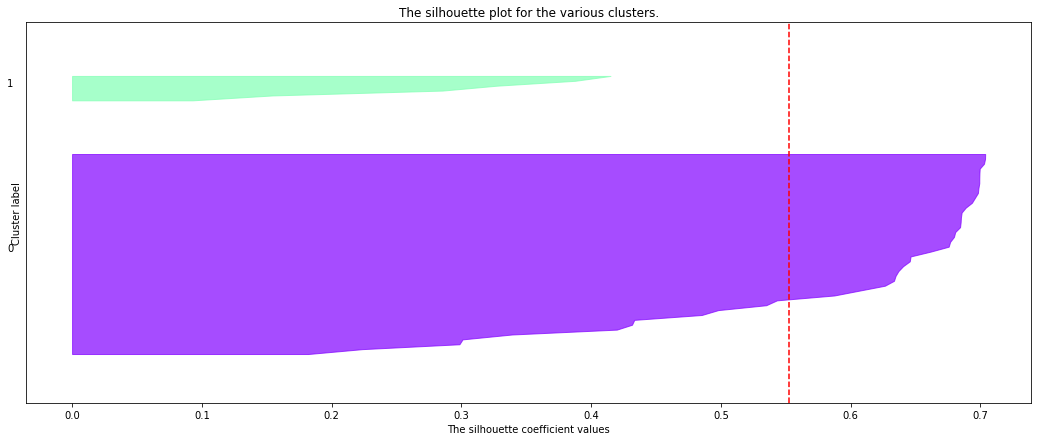

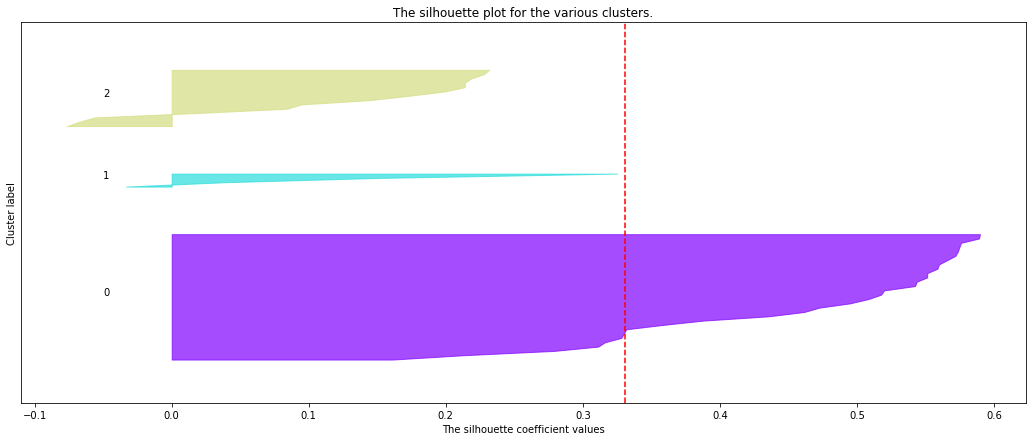

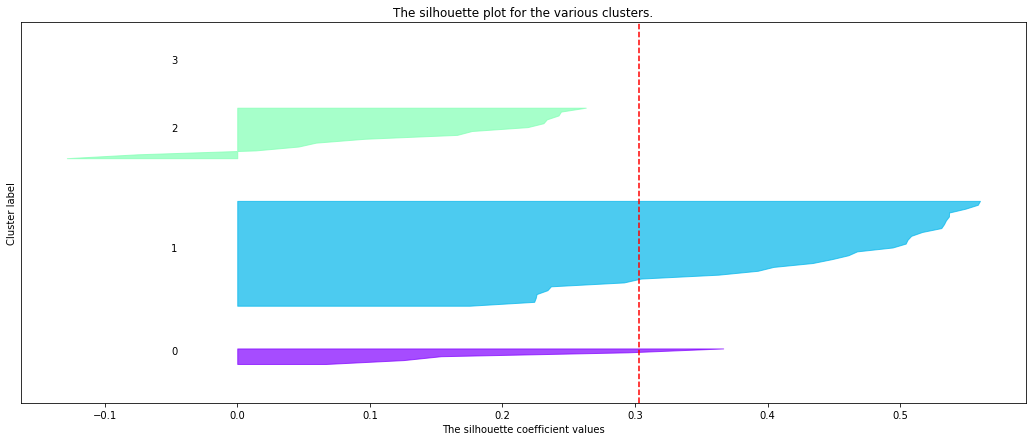

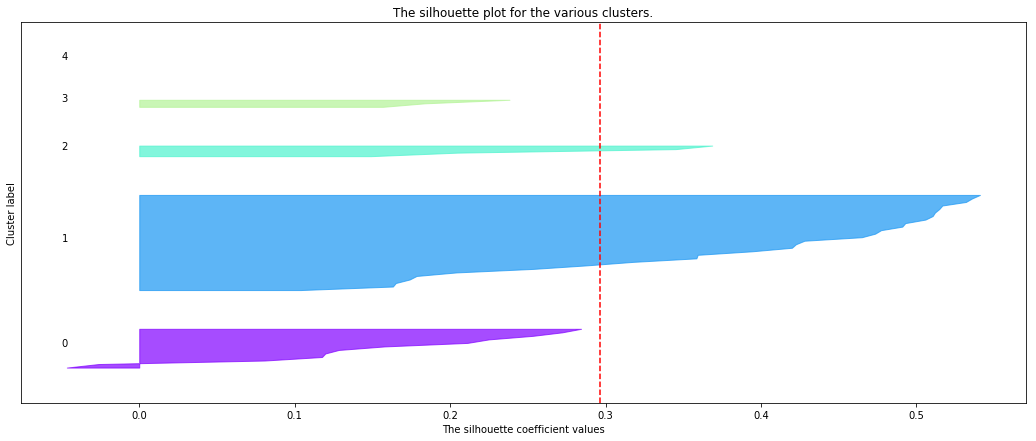

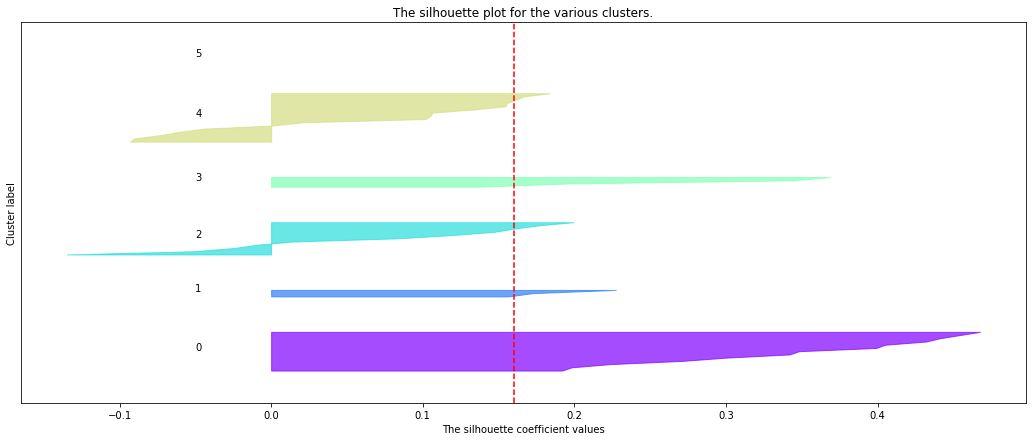

In [29]:
plot_silhouette(Spe, clusters)

In [176]:
clusters = range(2, 48)

plot_silhouette(normdFY.T, clusters)

For n_clusters = 2 The average silhouette_score is : 0.14369289114361558
For n_clusters = 3 The average silhouette_score is : 0.1736388035993145
For n_clusters = 4 The average silhouette_score is : 0.13853190050524808
For n_clusters = 5 The average silhouette_score is : 0.1379071000933776
For n_clusters = 6 The average silhouette_score is : 0.02007233226304303
For n_clusters = 7 The average silhouette_score is : 0.02149513887591591
For n_clusters = 8 The average silhouette_score is : 0.03582444928591301
For n_clusters = 9 The average silhouette_score is : 0.07885655358000666
For n_clusters = 10 The average silhouette_score is : 0.0047143611527672965
For n_clusters = 11 The average silhouette_score is : 0.024124148207679816
For n_clusters = 12 The average silhouette_score is : 0.030256718762248173
For n_clusters = 13 The average silhouette_score is : 0.011148626018591264
For n_clusters = 14 The average silhouette_score is : 0.04010379800386609
For n_clusters = 15 The average silhouette_

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


For n_clusters = 22 The average silhouette_score is : 0.014836415572539374
For n_clusters = 23 The average silhouette_score is : 0.03210982275342595
For n_clusters = 24 The average silhouette_score is : 0.02998633612215737
For n_clusters = 25 The average silhouette_score is : 0.029538739886782888
For n_clusters = 26 The average silhouette_score is : 0.03649741841831044
For n_clusters = 27 The average silhouette_score is : 0.023215445870980095
For n_clusters = 28 The average silhouette_score is : 0.02051899278008441
For n_clusters = 29 The average silhouette_score is : 0.03625038545741508
For n_clusters = 30 The average silhouette_score is : 0.004526212191136011
For n_clusters = 31 The average silhouette_score is : 0.041156347493942015
For n_clusters = 32 The average silhouette_score is : 0.0415701875248436
For n_clusters = 33 The average silhouette_score is : 0.036221288583475654
For n_clusters = 34 The average silhouette_score is : 0.031121023989981594
For n_clusters = 35 The average 

## Hierarchical cluster

In [72]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

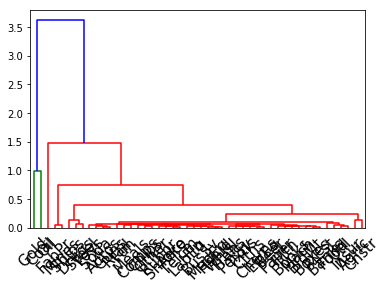

In [78]:
Z = hierarchy.linkage(MV, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=MV.index, leaf_rotation=45, leaf_font_size = 15)

## this is the corr distance it is using in package: 1-abs(corr)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage



In [79]:
def record_nodes_infor(Z):
    nodes = {}
    for i in range(48, 95):
        nodes[i] = list()
        for j in [0, 1]:
            if Z[i-48, j] <= 47:
                nodes[i].append(Z[i-48, j])
            elif (Z[i-48, j] > 47) & (Z[i-48, j] < i):
                nodes[i] = nodes[i]+nodes[Z[i-48, j]]

            else:
                print("Shit! Logic is wrong!!")
        nodes[i].sort()
    return nodes

In [80]:
def record_nodes_names(data, Z):
    names = {}
    for i in range(48, 95):
        names[i] = list()
        for j in [0, 1]:
            if Z[i-48, j] <= 47:
                names[i].append(data.T.index[int(Z[i-48, j])])
            elif (Z[i-48, j] > 47) & (Z[i-48, j] < i):
                names[i] = names[i]+names[Z[i-48, j]]

            else:
                print("Shit! Logic is wrong!!")
        names[i].sort()
    return names

In [81]:

def update_counts(realN, bootN, counts):
    for c in range(48, 95):
        real = realN[c]
        reallen = len(real)
        for d in range(48, 95):
            if len(bootN[d]) == reallen:
                if np.all(np.asarray(bootN[d]) == np.asarray(real)):
                    counts[c] = counts[c] + 1


In [82]:
def cross_validation(data, method, metric, B):
    ZR = hierarchy.linkage(data.T, method=method, metric=metric)
    realN = record_nodes_infor(ZR)

    record = {}
    for re in range(48, 95):
        record[re] = 0
    for i in range(B):
        boot = data.sample(frac=1, replace=True, axis=0)
        ZB = hierarchy.linkage(boot.T, method=method, metric=metric)
        bootN = record_nodes_infor(ZB)
        update_counts(realN, bootN, counts=record)

    return record, ZR

In [97]:
def Hierarchy_cluster(data, method, metric, B=1000, threshold=500):
    frequancy, Z = cross_validation(data, method=method, metric=metric, B=B)
    level5 = list()
    level6 = list()
    level7 = list()
    level8 = list()
    level9 = list()

    for key in frequancy.keys():
        if (frequancy[key] >= threshold) & (frequancy[key] < threshold+100):
            level5.append(key)
            
        elif (frequancy[key] >= threshold+100) & (frequancy[key] < threshold+200):
            level6.append(key)

        elif (frequancy[key] >= threshold+200) & (frequancy[key] < threshold+300):
            level7.append(key)
            
        elif (frequancy[key] >= threshold+300) & (frequancy[key] < threshold+400):
            level8.append(key)
            
        elif (frequancy[key] >= threshold+400):
            level9.append(key)
            
    link_cols = {}
    for i  in range(48):
        if (i+48) in level5:
            link_cols[i+48] = 'r'
        elif (i+48) in level6:
            link_cols[i+48] = 'b'
        elif (i+48) in level7:
            link_cols[i+48] = 'm'
        elif (i+48) in level8:
            link_cols[i+48] = 'g'
        elif (i+48) in level9:
            link_cols[i+48] = 'k'

        else:
            link_cols[i+48] = 'y'
    plt.figure()
    dn = hierarchy.dendrogram(Z, labels=data.T.index, 
                          link_color_func=lambda x: link_cols[x], leaf_rotation=45, leaf_font_size = 15)
    #plt.xlabel('48 industries', fontsize=20)
    plt.ylabel('distance', fontsize=25)
    plt.title(f'Hierarchical clusters with {method} linkage and {metric} as dissimilarity measure', fontsize=20)

    
    namelist = record_nodes_names(data, Z)
    for kept in level7:
        print(namelist[kept])

In [151]:
%matplotlib tk

In [177]:
Hierarchy_cluster(normdFY, 'single', 'correlation')

['BusSv', 'Comps']
['Autos', 'Banks', 'BldMt', 'BusSv', 'Chems', 'Chips', 'Comps', 'Fin', 'Insur', 'LabEq', 'Mach', 'Whlsl']
['Autos', 'Banks', 'BldMt', 'BusSv', 'Chems', 'Chips', 'Cnstr', 'Comps', 'Fin', 'Insur', 'LabEq', 'Mach', 'MedEq', 'Steel', 'Telcm', 'Trans', 'Whlsl']
['Aero', 'Agric', 'Autos', 'Banks', 'Beer', 'BldMt', 'Books', 'Boxes', 'BusSv', 'Chems', 'Chips', 'Clths', 'Cnstr', 'Coal', 'Comps', 'Drugs', 'ElcEq', 'FabPr', 'Fin', 'Food', 'Fun', 'Guns', 'Hlth', 'Hshld', 'Insur', 'LabEq', 'Mach', 'Meals', 'MedEq', 'Mines', 'Oil', 'Other', 'Paper', 'PerSv', 'RlEst', 'Rtail', 'Rubbr', 'Ships', 'Smoke', 'Soda', 'Steel', 'Telcm', 'Toys', 'Trans', 'Txtls', 'Util', 'Whlsl']


In [178]:
Hierarchy_cluster(normdFY, 'single', 'euclidean')

['BusSv', 'Comps']
['Autos', 'Banks', 'BldMt', 'BusSv', 'Chems', 'Chips', 'Comps', 'Fin', 'Insur', 'LabEq', 'Mach', 'Whlsl']
['Autos', 'Banks', 'BldMt', 'BusSv', 'Chems', 'Chips', 'Cnstr', 'Comps', 'Fin', 'Insur', 'LabEq', 'Mach', 'MedEq', 'Steel', 'Telcm', 'Trans', 'Whlsl']
['Aero', 'Autos', 'Banks', 'BldMt', 'Books', 'Boxes', 'BusSv', 'Chems', 'Chips', 'Clths', 'Cnstr', 'Comps', 'Drugs', 'ElcEq', 'Fin', 'Food', 'Fun', 'Hlth', 'Hshld', 'Insur', 'LabEq', 'Mach', 'Meals', 'MedEq', 'Mines', 'Oil', 'Paper', 'PerSv', 'RlEst', 'Rtail', 'Rubbr', 'Ships', 'Steel', 'Telcm', 'Trans', 'Txtls', 'Whlsl']


In [179]:
Hierarchy_cluster(normdFY, 'average', 'correlation')

['BusSv', 'Comps']
['BldMt', 'Cnstr']


In [180]:
Hierarchy_cluster(normdFY, 'average', 'euclidean')

['BusSv', 'Comps']
['Banks', 'Insur']
['BldMt', 'Cnstr']


In [181]:
Hierarchy_cluster(normdFY, 'complete', 'correlation')

['BusSv', 'Comps']
['BusSv', 'Chips', 'Comps', 'LabEq', 'Telcm']
['Food', 'Util']
['Food', 'Smoke', 'Util']
['Beer', 'Food', 'Smoke', 'Soda', 'Util']


In [182]:
Hierarchy_cluster(normdFY, 'complete', 'euclidean')

['BusSv', 'Comps']
['Banks', 'Insur']
['Food', 'Util']
['Food', 'Smoke', 'Util']
['Beer', 'Food', 'Smoke', 'Soda', 'Util']


In [197]:
from scipy.sparse.csgraph import minimum_spanning_tree as MST
import networkx as nx


In [204]:
nx.minimum_spanning_tree(T)

AttributeError: is_directed not found

In [199]:
#%matplotlib tk
T = MST(corr)

plt.figure()
nx.draw_networkx(T, with_labels=False, node_size = 15)
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)

## Start PCA here

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [46]:
%matplotlib tk

In [191]:
pca = PCA(n_components=None)
results = pca.fit(normdFY)

In [192]:
eigenvalues = results.explained_variance_

In [193]:
explained_portion = results.explained_variance_ratio_

In [194]:
plt.hist(eigenvalues, 250)
plt.xlabel('eigenvalues', fontsize=20)
plt.ylabel('counts', fontsize=20)
plt.title('Histogram of eigenvalues', fontsize=20)
plt.show()

In [195]:
plt.figure()
plt.plot(explained_portion, '-.2r')
plt.plot(np.cumsum(explained_portion), '-.2b')
plt.xlabel('nth largest eigenvalue', fontsize=20)
plt.ylabel('precentage', fontsize=20)
plt.legend(['individual', 'cumulative'], fontsize=20)
plt.title('Perportion explained by eigenvalues', fontsize=20)

Text(0.5,1,'Perportion explained by eigenvalues')

In [205]:
a = list()
f, a = plt.subplots(4, sharex=True, sharey=True)
a[0].set_title('Contribution to eigenvectors from assets', fontsize=20)

for i in range(4):

    vector = abs(results.components_[i])
    a[i].plot(range(len(vector)), vector)
    a[i].plot(np.ones(len(vector))*np.mean(vector))
    a[i].tick_params(axis='y', labelsize=20)
    a[i].set_ylabel("weight", fontsize=18)
    a[i].grid(color='y', linestyle='-', linewidth=0.5)
plt.xticks(range(len(normdFY.columns)), list(normdFY.columns), rotation=45, fontsize=22)
a[3].set_xlabel('48 industries', fontsize=20)



Text(0.5,0,'48 industries')

In [206]:
explained_portion

array([0.59361882, 0.04123902, 0.03030606, 0.02147191, 0.01615129,
       0.01517516, 0.01467287, 0.014339  , 0.0132198 , 0.01308558,
       0.01275696, 0.01182973, 0.01132693, 0.01081662, 0.01000696,
       0.00948463, 0.00913775, 0.00901146, 0.00821647, 0.00790752,
       0.00774869, 0.00739584, 0.00696744, 0.00678581, 0.00650472,
       0.00635083, 0.00596797, 0.00591381, 0.00577937, 0.00568354,
       0.00548661, 0.00526929, 0.00487639, 0.00466871, 0.00448678,
       0.00419129, 0.00359829, 0.0034811 , 0.00347009, 0.00327801,
       0.00306547, 0.00299163, 0.00249821, 0.00237005, 0.00216503,
       0.00214194, 0.00158875, 0.00149979])

Assuming the first vector is market, and according to these weights, I should be able to construct a portfolio that represents the market and can be use as a market index.

If I invest in this index, I will only profit from market movement

If I invest in other asset, and want to hedge the risk from market then I long this asset and short this market index.

How to test?


In [138]:
def Markowitz_weights_optIneq(Sigma, mean_returns, mu_p_vect, market, vertical = True, print_info = False, muConstr=False):
    
    n = Sigma.shape[0]    
    mu_p_vect = np.array(mu_p_vect)
    mu_p_vect.shape = (mu_p_vect.size,)
    # previous lines: to convert into array in case that mu_p is a single number
    portfolios = []
    x0 = np.ones(n)/n

    cost_fun = lambda x: (x@Sigma)@x
    
    for mu_p in mu_p_vect:        
        if muConstr:
        
            if vertical:
                cons = ({'type': 'ineq', 'fun': lambda x: x@mean_returns - mu_p},
                        {'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1},
                        {'type': 'eq', 'fun': lambda x: x@market})

            
            else:
                cons = ({'type': 'ineq', 'fun': lambda x: x@mean_returns - mu_p},
                        {'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1})


        else:
            
            if vertical:

                cons = ({'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1},
                        {'type': 'eq', 'fun': lambda x: x@market})

            else:
                
                cons = ({'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1})
                
        # Calculate efficient frontier weights using quadratic programming
        res = minimize(cost_fun, x0, method = 'SLSQP', constraints=cons)
        if print_info:
            print(mu_p, res)
        portfolios.append(res.x)
        
    # Calculate efficient frontier weights using quadratic programming
    #portfolios = [opt.solvers.qp(S, opt.matrix(np.zeros(n)), G, h, A, opt.matrix([1.0,mu]))['x'] 
    #              for mu in mu_p]

    # Turning the portfolios into a numpy array
    portfolios = np.array([np.array(p).squeeze() for p in portfolios])
    
    return portfolios

In [140]:
def moving_window_outOfSample(data, train=250, hold=63, mu=0.03,  muConstr=False):
    startTrain = 0
    report = pd.DataFrame(columns=['meanVer', 'meanNai', 'corrVer', 'corrNai'], index=range(100), dtype=float)
    
    for i in range(int((len(data)-train)/hold)):
        
        trainSet = data.iloc[startTrain : startTrain+train]
        holdSet = data.iloc[startTrain+train : startTrain+train+hold]
        returns = pd.DataFrame(columns=['Vertical', 'Naive', 'Equal'], index=holdSet.index, dtype=float)
        startTrain = startTrain+hold
        
        sigma = trainSet.cov()
        mean_return = np.asarray(trainSet.mean())
        pca = PCA(n_components=None)
        results = pca.fit(trainSet)
        market = results.components_[0]
        
        portVertical = Markowitz_weights_optIneq(sigma, mean_return, mu, market, muConstr=muConstr)
        portNaive = Markowitz_weights_optIneq(sigma, mean_return, mu, market, vertical=False, muConstr=muConstr)

        holdRe_vertical = holdSet @ portVertical.T
        holdRe_naive = holdSet @ portNaive.T
        
        meanVer = holdRe_vertical.mean()
        meanNai = holdRe_naive.mean()
        
        equalPort = holdSet.mean(1)
        
        returns['Vertical'] = holdRe_vertical
        returns['Naive'] = holdRe_naive
        returns['Equal'] = equalPort
        
        corr = returns.corr()
        
        report['meanVer'][i] = meanVer
        report['meanNai'][i] = meanNai
        report['corrVer'][i] = corr['Vertical']['Equal']
        report['corrNai'][i] = corr['Naive']['Equal']
        
    return report
        

In [133]:
MV_ten, _, _, _, _ = get_feature_Matrices(tenY)

In [134]:
normdTenY = pd.DataFrame(columns=tenY.columns, index=tenY.index, dtype=float)
for col in tenY:
    normdTenY[col] = (tenY[col] - MV_ten['mean'][col]) / (MV_ten['var'][col]**0.5)

In [211]:
vertical_port = moving_window_outOfSample(normdTenY, train=250, hold=63, mu=0.03)
plt.figure()
plt.plot(vertical_port['corrVer'], '-2r')
plt.plot(vertical_port['corrNai'], '-2b')
print(vertical_port['meanVer'].mean())
print(vertical_port['meanNai'].mean())
plt.xlabel('Holding periods', fontsize=22)
plt.ylabel('Pearson Correlations', fontsize=22)
plt.legend(['Vertical portfolio', 'Markowitz portfolio'], fontsize=22)

0.008702526218408693
0.010885132417773164


In [213]:
vertical_port = moving_window_outOfSample(normdTenY, train=250, hold=63, mu=0.03, muConstr=True)
plt.figure()
plt.plot(vertical_port['corrVer'], '-2r')
plt.plot(vertical_port['corrNai'], '-2b')
print(vertical_port['meanVer'].mean())
print(vertical_port['meanNai'].mean())
plt.xlabel('Holding periods', fontsize=22)
plt.ylabel('Pearson Correlations', fontsize=22)
plt.legend(['Vertical portfolio', 'Markowitz portfolio'], fontsize=22)

0.005394979240347682
0.006972921233944473


In [209]:
vertical_port = moving_window_outOfSample(normdTenY, train=250, hold=125, mu=0.03, muConstr=True)
plt.figure()
plt.plot(vertical_port['corrVer'], '-2r')
plt.plot(vertical_port['corrNai'], '-2b')
print(vertical_port['meanVer'].mean())
print(vertical_port['meanNai'].mean())
plt.xlabel('Holding periods', fontsize=22)
plt.ylabel('Pearson Correlations', fontsize=22)
plt.legend(['Vertical portfolio', 'Markowitz portfolio'], fontsize=22)

0.006792452201839038
0.00834917107221357


In [210]:
vertical_port = moving_window_outOfSample(normdTenY, train=250, hold=125, mu=0.03)
plt.figure()

plt.plot(vertical_port['corrVer'], '-2r')
plt.plot(vertical_port['corrNai'], '-2b')
print(vertical_port['meanVer'].mean())
print(vertical_port['meanNai'].mean())
plt.xlabel('Holding periods', fontsize=22)
plt.ylabel('Pearson Correlations', fontsize=22)
plt.legend(['Vertical portfolio', 'Markowitz portfolio'], fontsize=22)

0.007392556043315821
0.011321533578720708
